In [1]:
### USING ENV indigene-img2
import os
import torch
# import wandb
# from torchinfo import summary
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
# import argparse
import torchvision.models as models
import pandas as pd
import skimage as ski
from torch.utils.data import Dataset, DataLoader, random_split
# from torchvision.transforms import v2 as transforms
import matplotlib.pyplot as plt
import numpy as np
import umap
import scanpy as sc
import re
import random
from torchvision.transforms import v2 as transforms

/hps/software/users/birney/esther/micromamba/envs/indigene-img2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
! module load cuda/12.2.0

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
from models import VariationalAutoEncoderResNet, VariationalAutoEncoderConv

vae = VariationalAutoEncoderResNet((3, 224, 224), latent_dim=128)

/hps/software/users/birney/esther/micromamba/envs/indigene-img2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hps/software/users/birney/esther/micromamba/envs/indigene-img2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001)
# checkpoint = torch.load("/hps/nobackup/birney/users/esther/medaka-img/models/checkpoints/vae-pytorch-medaka/tough-donkey-26/ckpt-model-convnet-vae-run-tough-donkey-26-epoch-299-time-2025-02-20-1619.pt")
checkpoint = torch.load("/hps/nobackup/birney/users/esther/medaka-img/models/checkpoints/vae-pytorch-medaka/balmy-dream-31/ckpt-model-convnet-vae-run-balmy-dream-31-epoch-499-time-2025-02-20-2154.pt")

vae.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [6]:
from data import MinMaxScaling
import data

dataset = MedakaDataset(data_csv='/nfs/research/birney/users/esther/medaka-img/src_files/train_set_2024-10-03 copy.csv',
                        direction_csv='/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv', 
                        src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/', 
                        transform=data.transform()
                        )

/hps/software/users/birney/esther/micromamba/envs/indigene-img2/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [16]:
vae = vae.to(device)
vae.eval()
mean_matrix = {}
var_matrix = {}
counter = 0

for image, image_name in dataset:
    image = image.to(device)  # Convert image to a PyTorch tensor
    mean, var = vae.get_latent(image.unsqueeze(0).to(device))
    mean_matrix[image_name] = mean.detach().cpu().numpy().reshape(128)
    var_matrix[image_name] = var.detach().cpu().numpy().reshape(128)

    if counter % 10 == 0:
        print(counter)

    counter += 1

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100


KeyError: 1108

In [21]:
mean_df = pd.DataFrame.from_dict(mean_matrix, orient='index')
mean_df

var_df = pd.DataFrame.from_dict(var_matrix, orient='index')
var_df

mean_df.to_csv('/nfs/research/birney/users/esther/medaka-img/features/resnet-vae-pytorch-medaka/balmy-dream-31/mean_matrix.csv')
var_df.to_csv('/nfs/research/birney/users/esther/medaka-img/features/resnet-vae-pytorch-medaka/balmy-dream-31/var_matrix.csv')

In [7]:
# Load mean, var
# mean_df = pd.read_csv('/nfs/research/birney/users/esther/medaka-img/features/convnet-vae-pytorch-medaka/tough-donkey-26-epoch299/mean_matrix.csv')
mean_df = pd.read_csv('/nfs/research/birney/users/esther/medaka-img/features/resnet-vae-pytorch-medaka/balmy-dream-31/mean_matrix.csv')
mean_df = mean_df.set_index('Unnamed: 0')

# var_df = pd.read_csv('/nfs/research/birney/users/esther/medaka-img/features/convnet-vae-pytorch-medaka/tough-donkey-26-epoch299/var_matrix.csv')
var_df = pd.read_csv('/nfs/research/birney/users/esther/medaka-img/features/resnet-vae-pytorch-medaka/balmy-dream-31/var_matrix.csv')
var_df = var_df.set_index('Unnamed: 0') # 1108 rows, 128 columns

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

var_df

In [8]:
cross_mapping = {
    'Female 14-2 F14 x Male 10-1 F14': '14-2_x_10-1',
    'Female 14-2 F14 x Male 129-1 F14': '14-2_x_129-1',
    'Female 14-2 F14 x Male 33-1 F14': '14-2_x_33-1',
    'Female 14-2 F14 x Male 60-1 F14': '14-2_x_60-1',
    'Female 14-2 F14 x Male 72-1 F14': '14-2_x_72-1',
    'Female 95-1 F14 x Male 10-1 F14': '95-1_x_10-1',
    'Female 95-1 F14 x Male 129-1 F14': '95-1_x_129-1',
    'Female 95-1 F14 x Male 33-1 F14': '95-1_x_33-1',
    'Female 95-1 F14 x Male 72-1 F14': '95-1_x_72-1',
    'Male 11-2 F14 x Female 14-2 F14': '11-2_x_14-2',
    'Male 11-2 F15 x Female 72-1 F14': '11-2_x_72-1',
    'Male 14-2 F14 x Female 10-1 F14': '14-2_x_10-1',
    'Male 14-2 F14 x Female 33-1 F14': '14-2_x_33-1',
    'Male 14-2 F14 x Female 60-1 F14': '14-2_x_60-1',
    'Male 14-2 F14 x Female 72-1 F14': '14-2_x_72-1',
    'Male 95-1 F14 x Female 10-1 F14': '95-1_x_10-1',
    'Male 95-1 F14 x Female 129-1 F14': '95-1_x_129-1',
    'Male 95-1 F14 x Female 33-1 F14': '95-1_x_33-1',
    'Male 95-1 F14 x Female 72-1 F14': '95-1_x_72-1'
}

In [9]:
latents_mean = []
latents_var = []
indices = []
labels = []

for index, row in mean_df.iterrows():
    mean = torch.tensor(row.values)
    var = torch.tensor(var_df.loc[index].values)

    latents_mean.append(mean)
    latents_var.append(var)

    indices.append(index)

    cross_pattern = r"(Female \d+-\d+ F\d+ x Male \d+-\d+ F\d+|Male \d+-\d+ F\d+ x Female \d+-\d+ F\d+)"
    match = re.search(cross_pattern, index)
    if match:
        label = match.group(0)
        total_cross = cross_mapping.get(label, "Unknown cross")
        labels.append(total_cross)

    # labels.append(re.search(cross_pattern, index).group(0))

latents_mean = torch.stack(latents_mean, dim=0)
latents_var = torch.stack(latents_var, dim=0)

In [13]:
labels

['95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_72-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_72-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '95-1_x_129-1',
 '

In [14]:
# labels[labels=="Female 14-2 F14 x Male 10-1 F14"]
# latents_mean[labels=="Female 14-2 F14 x Male 10-1 F14"]
labels_idx = [i for i, label in enumerate(labels) if label == 'Female 14-2 F14 x Male 129-1 F14']
labels_idx = [i for i, label in enumerate(labels) if label == '14-2_x_129-1']

print(labels_idx)

print(len(labels_idx))

[357, 358, 359, 360, 361, 362, 363, 365, 366, 367, 368, 503, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 531, 532, 659, 660, 661, 662, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 956, 957]
69


In [15]:
np.unique(labels)

array(['11-2_x_14-2', '11-2_x_72-1', '14-2_x_10-1', '14-2_x_129-1',
       '14-2_x_33-1', '14-2_x_60-1', '14-2_x_72-1', '95-1_x_10-1',
       '95-1_x_129-1', '95-1_x_33-1', '95-1_x_72-1'], dtype='<U12')

In [10]:
# For each cross, get the mean and std of the latents
# Store in a dictionary where the key is the cross name and the value is a list of the mean and var

crosses_mean = {}

for cross_name in np.unique(labels):
    labels_cross_idx = [i for i, label in enumerate(labels) if label == cross_name]
    latents_mean_cross = latents_mean[labels_cross_idx]
    latents_mean_cross = latents_mean_cross.mean(dim=0, keepdims=True)

    latents_var_cross = latents_var[labels_cross_idx]
    latents_var_cross = latents_var_cross.mean(dim=0, keepdims=True)

    crosses_mean[cross_name] = [latents_mean_cross, latents_var_cross]

In [11]:
print(crosses_mean.keys()) 

dict_keys([np.str_('11-2_x_14-2'), np.str_('11-2_x_72-1'), np.str_('14-2_x_10-1'), np.str_('14-2_x_129-1'), np.str_('14-2_x_33-1'), np.str_('14-2_x_60-1'), np.str_('14-2_x_72-1'), np.str_('95-1_x_10-1'), np.str_('95-1_x_129-1'), np.str_('95-1_x_33-1'), np.str_('95-1_x_72-1')])


In [16]:
means_dict = {}
vars_dict = {}

for index, row in mean_df.iterrows():
    latent_sampled = []
    mean = torch.tensor(row.values)
    var = torch.tensor(var_df.loc[index].values)
    std = torch.exp(0.5 * var) # (1, 128)
    for i in range(1000):
        eps = torch.randn_like(mean)
        z = eps * std + mean # (1, 128) sampled latent vector

        latent_sampled.append(z.numpy())

    cross_pattern = r"(Female \d+-\d+ F\d+ x Male \d+-\d+ F\d+|Male \d+-\d+ F\d+ x Female \d+-\d+ F\d+)"
    match = re.search(cross_pattern, index)
    if match:
        label = match.group(0)
        total_cross = cross_mapping.get(label, "Unknown cross")
    
    means_dict[total_cross] = latent_sampled

# latent_sampled_df = pd.DataFrame(latent_sampled)
# latent_sampled_df.index = mean_df.index

# latent_sampled_df

In [20]:
means_dict['95-1_x_72-1']

[array([ 0.61135459,  0.55069553,  0.13746034, -0.58778549, -0.39283143,
         0.45655932,  0.75941237,  0.49663354,  0.57246948, -0.04747576,
         0.90798397,  0.41005756, -0.27628845, -0.17234624,  0.49614394,
         0.50732317,  0.02300602, -0.84009741, -0.012466  ,  0.49533181,
         0.0072042 ,  0.36238717,  0.43993557, -0.08545235,  0.45980277,
         0.96957395, -0.10285205, -0.05904662, -0.11553095,  0.16693212,
        -0.74076387,  0.67185531,  0.08400623, -0.24516376,  0.13885358,
         0.40829527, -0.13661329,  0.60289183, -0.48176572,  0.46161483,
        -0.00848802,  0.61723484,  0.41891475,  1.06062987, -0.28586019,
         0.73512576, -0.08013194, -0.04613272, -0.40909578,  0.13903046,
         0.5361598 , -0.16776205,  0.49545984,  0.47746478, -0.18857395,
         0.63398857, -0.70944136, -0.23298314, -0.56422949,  0.27214874,
         0.58605695, -0.19366931,  0.13549682, -0.03207193,  0.4702895 ,
        -0.17271277,  0.35916478, -0.73251841,  0.5

In [14]:
cross_pairs = ['14-2_x_10-1', '14-2_x_72-1']

14-2_x_10-1


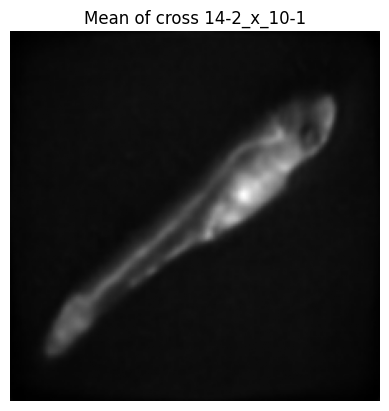

14-2_x_72-1


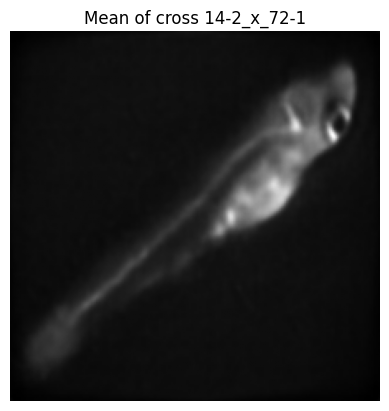

In [15]:
### PLOT THE MEANS OF THE TWO CROSSES
vae = vae.to(device)
vae.eval()
# for cross_name in ['Female 14-2 F14 x Male 72-1 F14', 'Female 95-1 F14 x Male 33-1 F14']: # crosses_mean.keys(): Female 14-2 F14 x Male 10-1 F14
for cross_name in cross_pairs: # crosses_mean.keys(): Female 14-2 F14 x Male 10-1 F14
    print(cross_name)
    latents_mean_cross, latents_var_cross = crosses_mean[cross_name]

    # std = torch.exp(0.5 * latents_var_cross)
    # eps = torch.randn_like(latents_mean_cross)
    # cross_dist = eps * std + mean

    cross_dist = torch.distributions.Normal(latents_mean_cross, torch.exp(0.5 * latents_var_cross))

    percentiles = torch.linspace(0.05, 0.95, 20)
    samples_icdf = cross_dist.icdf(percentiles[:, None].repeat(1, 128))  # Compute the inverse CDF of the percentiles => dim = [20, 1, 128]

    # Plot the mean image
    with torch.no_grad():
        cross_img = vae.decode(latents_mean_cross.float().to(device), latents_var_cross.float().to(device))
        # cross_imgs = vae.decode(samples_icdf.to(device))
    
    plt.imshow(cross_img.squeeze().cpu().numpy().transpose(1, 2, 0)[:,:,0], cmap='gray')
    plt.title(f"Mean of cross {cross_name}")
    plt.axis('off')
    plt.show()

    ### PLOTTING THE DISTRIBUTION OF SAMPLES FOR A GIVEN LATENT DIMENSION
    # # Sample from the distribution
    # samples = cross_dist.sample((1000,))  # Sample 1000 points => dim = [1000, 1, 128]
    # print(samples_icdf.shape)
    # # print(samples)
    # # print(samples[:,0,:].shape) # [1000, 128]
    # # print(samples[0,:,:]) # [1, 128]
    # # print(samples[:,:,0]) # [1000, 1]

    # latent_dim = 0

    # # Convert to numpy for plotting
    # samples_np = samples[:,:,latent_dim].numpy()
    # samples_icdf_np = samples_icdf[:,latent_dim].numpy()
    # mean_value = latents_mean_cross[0,latent_dim].item()
    # print(f"Mean of the latent element: {mean_value}")
    # print(f"samples_icdf: {samples_icdf_np.shape}")

    # # Plot the samples
    # plt.figure(figsize=(10, 6))
    # _, bins, _ = plt.hist(samples_np, bins=30, density=True, alpha=0.6, label='x')
    # _ = plt.hist(samples_icdf_np, bins=bins, density=True, alpha=0.3, label='percent')
    # plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    # plt.title(f'Distribution of sampled {cross_name} for latent dimension {latent_dim}')
    # plt.xlabel('Value')
    # plt.ylabel('Density')
    # plt.show()


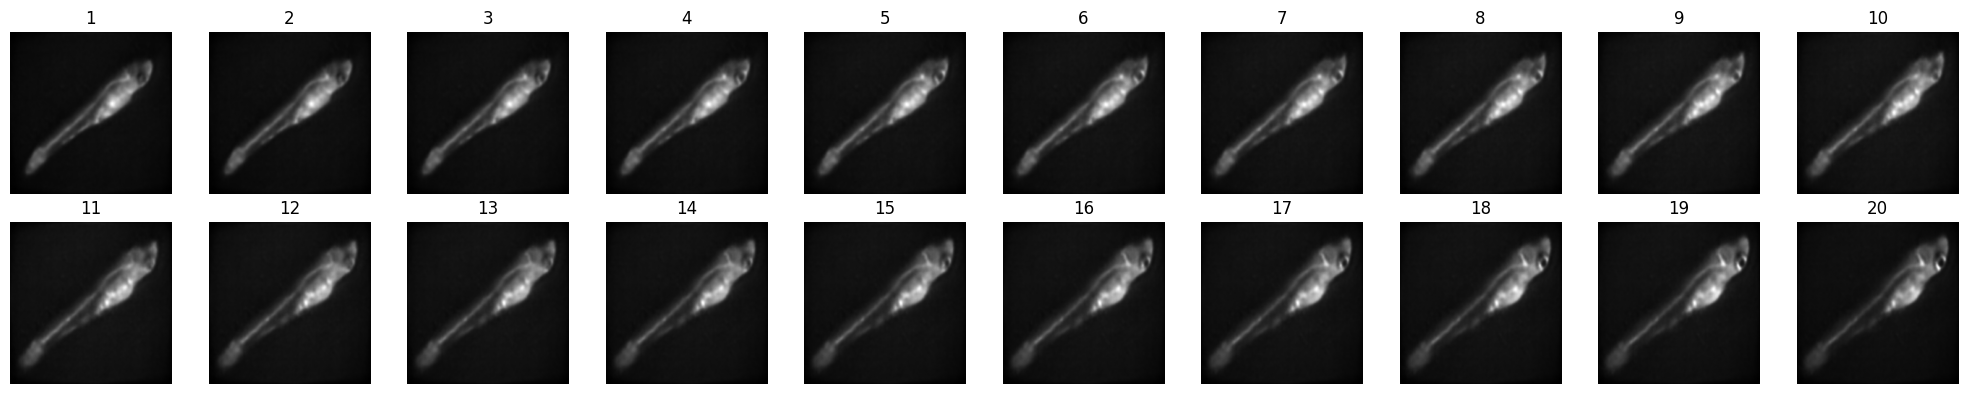

In [18]:
### PLOT INTERPOLATION BETWEEN THE MEANS OF TWO CROSSES
vae = vae.to(device)
vae.eval()

for start_class_id in range(1,10):
  start = crosses_mean[cross_pairs[0]][0].to(device) # [1, 128]
  for end_class_id in range(1, 10):
    if end_class_id == start_class_id:
      continue
    end = crosses_mean[cross_pairs[1]][0].to(device)
    interpolated_samples = linear_interpolation(start, end, steps = 20, logvar=crosses_mean['14-2_x_72-1'][1].to(device))
    # interpolated_samples2 = linear_interpolation(start, end, steps = 10, logvar=crosses_mean['Female 95-1 F14 x Male 33-1 F14'][1].to(device))


# interpolated_samples = torch.cat([interpolated_samples1, interpolated_samples2], dim=0)
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
# Plot each image in the grid
for i in range(20):
    ax = axes[i // 10, i % 10]
    image = interpolated_samples[i].squeeze().cpu().numpy()  # Shape will be [224, 224]
    ax.imshow(image.transpose(1, 2, 0)[:,:,0], cmap='gray')
    ax.set_title(f'{i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
def linear_interpolation(start, end, steps, logvar):
    # Create a linear path from start to end
    z = torch.linspace(0, 1, steps)[:, None].to(device) * (end - start) + start
    # Decode the samples along the path
    vae.eval()
    with torch.no_grad():
      samples = vae.decode(z.float(), logvar.float())
    return samples

In [19]:
metadata_map = pd.read_csv('/nfs/research/birney/users/esther/medaka-img/src_files/all_image_sample_name_metadata_map.csv')
metadata_map.crosses.unique()

array(['95-1_Female_x_72-1_Male', '95-1_Female_x_129-1_Male',
       '95-1_Male_x_129-1_Female', '14-2_Female_x_72-1_Male',
       '14-2_Male_x_72-1_Female', '95-1_Male_x_72-1_Female',
       '95-1_Female_x_33-1_Male', '95-1_Male_x_10-1_Female',
       '95-1_Female_x_10-1_Male', '14-2_Female_x_10-1_Male',
       '14-2_Female_x_60-1_Male', '14-2_Male_x_60-1_Female',
       '14-2_Female_x_33-1_Male', '14-2_Male_x_33-1_Female',
       '14-2_Female_x_129-1_Male', '95-1_Male_x_33-1_Female',
       '14-2_Male_x_10-1_Female', '11-2_Male_x_14-2_Female',
       '11-2_Male_x_72-1_Female'], dtype=object)

In [20]:
img_names = metadata_map[metadata_map['crosses'] == '14-2_Female_x_72-1_Male']['img_name']
img_names

168    PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_...
169    PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_...
170    PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_...
171    PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_...
172    PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_...
                             ...                        
600    PLATE 8 F2 VC_ Female 14-2 F14 x Male 72-1 F14...
601    PLATE 8 F2 VC_ Female 14-2 F14 x Male 72-1 F14...
602    PLATE 8 F2 VC_ Female 14-2 F14 x Male 72-1 F14...
603    PLATE 8 F2 VC_ Female 14-2 F14 x Male 72-1 F14...
604    PLATE 8 F2 VC_ Female 14-2 F14 x Male 72-1 F14...
Name: img_name, Length: 129, dtype: object

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

sampled_img_names = random.sample(img_names.tolist(), 9)
sampled_img_names

for name in sampled_img_names:
    img = get_image_by_name(dataset, name)
    ax = axes[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.set_title(name)
    ax.axis('off')


In [21]:
def get_image_by_name(dataset, img_name):
    for i in range(len(dataset)):
        if dataset[i][1] == img_name:
            return i

In [118]:
print(interpolated_samples.shape)

torch.Size([20, 1, 224, 224])


In [24]:
print(len(crosses_mean['Female 14-2 F14 x Male 129-1 F14']))

2


In [25]:
crosses_mean['Female 14-2 F14 x Male 129-1 F14'][0].shape

torch.Size([1, 128])

In [14]:
print(np.unique(labels))

['Female 14-2 F14 x Male 10-1 F14' 'Female 14-2 F14 x Male 129-1 F14'
 'Female 14-2 F14 x Male 33-1 F14' 'Female 14-2 F14 x Male 60-1 F14'
 'Female 14-2 F14 x Male 72-1 F14' 'Female 95-1 F14 x Male 10-1 F14'
 'Female 95-1 F14 x Male 129-1 F14' 'Female 95-1 F14 x Male 33-1 F14'
 'Female 95-1 F14 x Male 72-1 F14' 'Male 11-2 F14 x Female 14-2 F14'
 'Male 11-2 F15 x Female 72-1 F14' 'Male 14-2 F14 x Female 10-1 F14'
 'Male 14-2 F14 x Female 33-1 F14' 'Male 14-2 F14 x Female 60-1 F14'
 'Male 14-2 F14 x Female 72-1 F14' 'Male 95-1 F14 x Female 10-1 F14'
 'Male 95-1 F14 x Female 129-1 F14' 'Male 95-1 F14 x Female 33-1 F14'
 'Male 95-1 F14 x Female 72-1 F14']


### Plot UMAP

In [116]:
merged_df.crosses.unique()

array(['95-1_Female_x_72-1_Male', '95-1_Female_x_129-1_Male',
       '95-1_Male_x_129-1_Female', '14-2_Female_x_72-1_Male',
       '14-2_Male_x_72-1_Female', '95-1_Male_x_72-1_Female',
       '95-1_Female_x_33-1_Male', '95-1_Male_x_10-1_Female',
       '95-1_Female_x_10-1_Male', '14-2_Female_x_10-1_Male',
       '14-2_Female_x_60-1_Male', '14-2_Male_x_60-1_Female',
       '14-2_Female_x_33-1_Male', '14-2_Male_x_33-1_Female',
       '14-2_Female_x_129-1_Male', '95-1_Male_x_33-1_Female',
       '14-2_Male_x_10-1_Female', '11-2_Male_x_14-2_Female',
       '11-2_Male_x_72-1_Female'], dtype=object)

In [22]:
cross_mapping2 = {
    '95-1_Female_x_72-1_Male': '95-1_x_72-1', 
    '95-1_Female_x_129-1_Male': '95-1_x_129-1',
    '95-1_Male_x_129-1_Female': '95-1_x_129-1', 
    '14-2_Female_x_72-1_Male': '14-2_x_72-1',
    '14-2_Male_x_72-1_Female': '14-2_x_72-1', 
    '95-1_Male_x_72-1_Female': '95-1_x_72-1',
    '95-1_Female_x_33-1_Male': '95-1_x_33-1', 
    '95-1_Male_x_10-1_Female': '95-1_x_10-1',
    '95-1_Female_x_10-1_Male': '95-1_x_10-1', 
    '14-2_Female_x_10-1_Male': '14-2_x_10-1',
    '14-2_Female_x_60-1_Male': '14-2_x_60-1', 
    '14-2_Male_x_60-1_Female': '14-2_x_60-1',
    '14-2_Female_x_33-1_Male': '14-2_x_33-1',
    '14-2_Male_x_33-1_Female': '14-2_x_33-1',
    '14-2_Female_x_129-1_Male': '14-2_x_129-1', 
    '95-1_Male_x_33-1_Female': '95-1_x_33-1',
    '14-2_Male_x_10-1_Female': '14-2_x_10-1', 
    '11-2_Male_x_14-2_Female': '11-2_x_14-2',
    '11-2_Male_x_72-1_Female': '11-2_x_72-1'
}

In [33]:
metadata_map = pd.read_csv('/nfs/research/birney/users/esther/medaka-img/src_files/all_image_sample_name_metadata_map.csv')
merged_df = pd.merge(metadata_map[['img_name', 'crosses']], mean_df, right_index=True, left_on='img_name', how='inner')
merged_df['total_crosses'] = merged_df['crosses'].map(cross_mapping2)

# distinct_genomes = merged_df[merged_df['crosses'].isin(['95-1_Female_x_33-1_Male', 
#                                                         '95-1_Male_x_33-1_Female',
#                                                         '14-2_Female_x_72-1_Male',
#                                                         '14-2_Male_x_72-1_Female'])]

# distinct_genomes = merged_df[merged_df['crosses'].isin(['95-1_Female_x_33-1_Male', 
#                                                         '95-1_Male_x_33-1_Female',
#                                                         '14-2_Female_x_72-1_Male',
#                                                         '14-2_Male_x_72-1_Female',
#                                                         '14-2_Female_x_33-1_Male',
#                                                         '14-2_Male_x_33-1_Female'])]

distinct_genomes = merged_df[merged_df['total_crosses'].isin(['11-2_x_72-1', 
                                                        '11-2_x_14-2',
                                                        '14-2_x_72-1'])]

# distinct_genomes = merged_df[merged_df['total_crosses'].isin(cross_pairs)]

# distinct_genomes = merged_df

distinct_genomes_plate = pd.DataFrame(distinct_genomes)
distinct_genomes_plate['plate_number'] = distinct_genomes_plate['img_name'].str.extract(r'PLATE (\d+)')

In [34]:
distinct_genomes_plate['plate_number'].unique()

array(['3', '4', '6', '7', '8', '23', '24', '25'], dtype=object)

In [36]:
cols_to_drop = ['img_name', 'crosses', 'plate_number', 'total_crosses']
umap_input = distinct_genomes_plate.drop(cols_to_drop, axis=1)
# umap_input

adata = sc.AnnData(X = umap_input)
adata.obs['crosses'] = pd.Categorical(distinct_genomes_plate['total_crosses'])
adata.obs['plates'] = pd.Categorical(distinct_genomes_plate['plate_number'])
# adata.obs['check_plate14'] = pd.Categorical(distinct_genomes_plate['check_plate14'])

print(adata)
print(adata.obs.columns)

AnnData object with n_obs × n_vars = 232 × 128
    obs: 'crosses', 'plates'
Index(['crosses', 'plates'], dtype='object')


/hps/software/users/birney/esther/micromamba/envs/indigene-img2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


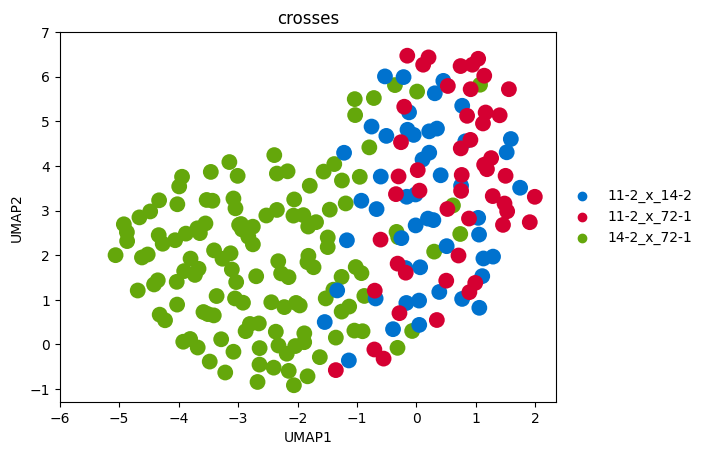

In [37]:
from colorir import *
seed = np.random.RandomState(seed=32)
palette = Palette(core_pink = "#D50032", core_blue = "#0072CE", core_orange = "#E87722", core_green = "#64A70B", core_purple = "#93328E", core_turquoise = "#00B0B9",
                 light_pink = "#E89CAE", light_blue = "#6CACE4", light_orange = "#F1BE48", light_green = "#B7BF10", light_purple = "#AF95A6", light_turquoise = "#85B09A",
                 dark_pink = "#A81538", dark_blue = "#003C71", dark_orange = "#BE4D00", dark_green = "#4E5B31", dark_purple = "#3F2A56", dark_turquoise = "#115E67",
                 gray="#D3D3D3")

sc.pp.neighbors(adata, n_neighbors=50, use_rep='X')

# Compute the UMAP

sc.tl.umap(adata, random_state=seed, alpha = 0.5)

# ax = sc.pl.umap(adata, color='crosses',
#                palette={cross_pairs[0]: palette.core_pink,
#                          cross_pairs[1]: palette.core_blue},
#                     show = False)

ax = sc.pl.umap(adata, color='crosses',
               palette={'11-2_x_72-1': palette.core_pink,
                         '11-2_x_14-2': palette.core_blue,
                         '14-2_x_72-1': palette.core_green},
                    show = False)

# ax = sc.pl.umap(adata, color='crosses',
#                 palette={'95-1_Female_x_72-1_Male': palette.gray, # palette.core_pink,
#                          '95-1_Male_x_72-1_Female': palette.gray, # palette.core_pink,
#                          '95-1_Male_x_129-1_Female': palette.gray, # palette.light_purple,
#                          '95-1_Female_x_129-1_Male': palette.gray, # palette.light_purple,
#                          '14-2_Female_x_72-1_Male': palette.gray, # palette.core_blue, #
#                          '14-2_Male_x_72-1_Female': palette.gray, # palette.core_blue, # 
#                          '95-1_Male_x_72-1_Female': palette.gray, # palette.core_orange,
#                          '95-1_Female_x_33-1_Male': palette.gray, # palette.core_green, #
#                          '95-1_Male_x_33-1_Female': palette.gray, # palette.core_green, #
#                          '95-1_Male_x_10-1_Female': palette.gray, # palette.core_purple,
#                          '95-1_Female_x_10-1_Male': palette.gray, # palette.core_purple,
#                          '14-2_Female_x_10-1_Male': palette.gray, # palette.core_turquoise,
#                          '14-2_Male_x_10-1_Female': palette.gray, # palette.core_turquoise,
#                          '14-2_Female_x_60-1_Male': palette.gray, # palette.light_pink,
#                          '14-2_Male_x_60-1_Female': palette.gray, # palette.light_pink,
#                          '14-2_Female_x_33-1_Male': palette.gray, # palette.light_blue,
#                          '14-2_Male_x_33-1_Female': palette.gray, # palette.light_blue,
#                          '14-2_Female_x_129-1_Male': palette.gray, # palette.light_orange,
#                          '11-2_Male_x_14-2_Female': palette.light_green,
#                          '11-2_Male_x_72-1_Female': palette.gray, # palette.light_green
#                         }, show = False)

# ax = sc.pl.umap(adata, color='crosses',
#                 groups = ['95-1_Female_x_33-1_Male', 
#                          '95-1_Male_x_33-1_Female',
#                          '14-2_Female_x_72-1_Male',
#                          '14-2_Male_x_72-1_Female',
#                          '14-2_Female_x_33-1_Male',
#                          '14-2_Male_x_33-1_Female'],
#                palette={'95-1_Female_x_33-1_Male': palette.core_pink,
#                          '95-1_Male_x_33-1_Female': palette.light_pink,
#                          '14-2_Male_x_72-1_Female': palette.core_blue,
#                          '14-2_Female_x_72-1_Male': palette.light_blue,
#                          '14-2_Female_x_33-1_Male': palette.core_green,
#                          '14-2_Male_x_33-1_Female': palette.light_green,},
#                     show = False)

ax.set_yticks(list(range(int(np.floor(min(adata.obsm['X_umap'][:, 1]))), 
                         int(np.ceil(max(adata.obsm['X_umap'][:, 1]))) + 1, 1)))
ax.set_xticks(list(range(int(np.floor(min(adata.obsm['X_umap'][:, 0]))), 
                         int(np.ceil(max(adata.obsm['X_umap'][:, 0]))) + 1, 1)))

In [5]:
# Create dataloader
class MedakaDataset(Dataset):
    """
    Custom dataset class for the medaka fish images.

    Attributes:
        image_paths (pd.Series):
            Pandas Series containing the paths to the images.
        src_dir (str):
            Directory containing the images.
        transform (Compose):
            Compose object containing the transformations to apply.
        direction_csv (str):
            Path to the CSV file containing whether the fish
            are facing left or right.
    """

    def __init__(self, data_csv, direction_csv, src_dir, transform):
        self.image_paths = pd.read_csv(data_csv)['img_name']
        self.src_dir = src_dir
        self.transform = transform

        # Load and process the CSV file containing the direction of the fish
        self.direction_csv = pd.read_csv(direction_csv)
        self.direction_csv = self.direction_csv[
            self.direction_csv['left_facing'] == 'left']
        self.direction_csv = self.direction_csv.rename(
            columns={'Unnamed: 0': 'img_name'})

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_base_name = os.path.splitext(img_name)[0]
        img_path = f'{self.src_dir}/raw_images/{img_name}'
        mask_path = f'{self.src_dir}/train_ilastik-masks-05112024/{img_base_name}_Simple Segmentation.tif'
        
        # image = ski.io.imread(img_path)[:, :, 0]
        image = ski.io.imread(img_path)
        
        # mask = ski.io.imread(mask_path)

        # Apply transformations
        if self.transform is not None:
            image = self.transform(image)

        # If facing left, flip the image horizontally
        img_base_name = os.path.splitext(img_name)[0]
        if img_base_name in self.direction_csv['img_name'].values:
            image = transforms.functional.hflip(image)

        ### Manual adjustments to odd images in training set
        # Manually flip the images where the fish head is facing down
        if img_name in ['PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_E04.tif', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_H7.tif']:
            image = transforms.functional.hflip(image)
            image = transforms.functional.vflip(image)

        # These fish are horizontal in the original image, so rotate them 45 degrees
        if img_name in ['PLATE 2 F2 VC_Male 95-1 F14 x Female 129-1 F14_D5.tif',
                        'PLATE 6 F2 VC_ Female 95-1 F14 x Male 72-1 F14_G5.tif',
                        'PLATE 23 F2 VC_ Male 11-2 F14 x Female 14-2 F14_G1.tif',
                        'PLATE 23 F2 VC_ Male 11-2 F14 x Female 14-2 F14_G4.tif',
                        'PLATE 23 F2 VC_ Male 11-2 F14 x Female 14-2 F14_G9.tif']:
            image = transforms.functional.rotate(image, 45)

        return image, img_name